## CREATE AND CUT THE GRAPH

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# !pip install leidenalg==0.7.0

In [3]:
%matplotlib inline
#%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

import torch
import numpy
import skimage.color
import torch.nn.functional as F
from MODULES.graph_clustering import *
import time
from typing import List, Tuple

## Helper function

In [4]:
def do_resolution_sweep(g, res_range, CPM_or_modularity):
    video_list, title_list, ncell_list, iou_list, resolution_list, mi_list, sizes_list = [], [], [], [], [], [], []
    for r in res_range:
        partition = g.find_partition_leiden(resolution=r, 
                                            CPM_or_modularity=CPM_or_modularity,
                                            each_cc_separately=False).filter_by_size(min_size=10)
        concordance = partition.concordance_with_partition(other_partition=g.partition_sample_segmask)
        
        mi_list.append(concordance.mutual_information)
        iou_list.append(concordance.iou)
        seg_mask = g.partition_2_mask(partition)
        video_list.append(seg_mask)
        resolution_list.append(r)
        ncell_list.append(len(partition.sizes)-1)
        sizes_list.append(partition.sizes.cpu().numpy())
        
    video = torch.stack(video_list, dim=0).cpu().numpy()

    mydict = {"video": video, 
              "ref_image": g.raw_image[0].cpu().numpy(), 
              "resolution_list": resolution_list, 
              "ncell_list": ncell_list,
              "mi_list": mi_list,
              "iou_list": iou_list,
              "sizes_list": sizes_list}
    return mydict

In [5]:
def show_video(dictionary: dict,
        figsize: Tuple[int, int] = (8, 4),
        interval: int = 50,
        nbins=10,
        hist_range=(0,200)):
    """
    :param video: an ndarray with shape (n_frames, height, width)
    :param title: an list of lenght (n_frames)    
    """
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=figsize)
    ax_video = axs[0,0]
    ax_image = axs[0,1]
    ax_graph = axs[1,0]
    ax_hist = axs[1,1]
    
    # image
    ax_video.axis('off')
    im = ax_video.imshow(skimage.color.label2rgb(dictionary["video"][0, ...], bg_label=0), aspect='equal')
    ax_video.set_title("title")

    # reference image
    ax_image.axis('off')
    _ = ax_image.imshow(dictionary["ref_image"], cmap='gray', aspect='equal')
    
    # graph
    color = 'tab:red'
    _ = ax_graph.plot(dictionary["resolution_list"], dictionary["ncell_list"], '.--', label="n_cell", color=color)
    ax_graph.set_xlabel("resolution")
    ax_graph.set_ylabel('n_cell', color=color)
    ax_graph.tick_params(axis='y', labelcolor=color)
    ax_graph.legend()
    ax_graph.grid()

    ax_graph_2 = ax_graph.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:green'
    _ = ax_graph_2.plot(dictionary["resolution_list"], dictionary["iou_list"], '-', label="iou", color=color)
    ax_graph_2.set_ylabel('iou', color=color)
    ax_graph_2.tick_params(axis='y', labelcolor=color)
    ax_graph_2.legend()
    
    # hist
    _ = ax_hist.hist(dictionary["sizes_list"][0][1:], range=hist_range, density=False, bins=nbins)
    ax_hist.set_title("title")
        
    plt.tight_layout()
    plt.close()
    
    def init():
        im.set_data(dictionary["video"][0, ...])
        ax_video.set_title("title")
        ax_hist.hist(dictionary["sizes_list"][0][1:], range=hist_range, density=False, bins=nbins)
        
    def animate(i):
        title = 'frame={0:3d} res={1:.3f} ncell={2:2d}'.format(i,dictionary["resolution_list"][i],
                                                               dictionary["ncell_list"][i])
        ax_video.imshow(skimage.color.label2rgb(dictionary["video"][i, ...], bg_label=0))
        ax_video.set_title(title)
        ax_hist.clear()
        ax_hist.hist(dictionary["sizes_list"][i][1:], range=hist_range, density=False, bins=nbins)
        ax_hist.set_title("PDF cell size")
        
    anim = animation.FuncAnimation(
        fig, animate, init_func=init, frames=dictionary["video"].shape[0],
        interval=interval)
    
    return HTML(anim.to_html5_video())

# Import files

In [6]:
# LARGE
#mask_file = "/Users/ldalessi/DAPI_unsupervised/spacetx-research/TILING_JULY/NEW_tiling_july9_radius5_SMALL.pt" 
#mask_file = "/Users/ldalessi/DAPI_unsupervised/spacetx-research/TILING_JULY/NEW_tiling_july9_radius5_SMALL_v2.pt" 
#mask_file = "/Users/ldalessi/DAPI_unsupervised/spacetx-research/TILING_JULY/NEW_tiling_july9_radius5_LARGE.pt" 
#mask_file = "/Users/ldalessi/DAPI_unsupervised/spacetx-research/TILING_JULY/NEW_tiling_july9_radius5_SMALL_v3.pt" 

mask_file_hard = "/Users/ldalessi/DAPI_unsupervised/spacetx-research/TILING_JULY/NEW_tiling_july17_radius10_HARD_EDGES.pt"
mask_file_dot = "/Users/ldalessi/DAPI_unsupervised/spacetx-research/TILING_JULY/NEW_tiling_july17_radius10_DOT_PRODUCT.pt"
mask_file_l1norm = "/Users/ldalessi/DAPI_unsupervised/spacetx-research/TILING_JULY/NEW_tiling_july17_radius10_L1_NORM.pt"
mask_file_l2norm = "/Users/ldalessi/DAPI_unsupervised/spacetx-research/TILING_JULY/NEW_tiling_july17_radius10_L2_NORM.pt"

# Load and plot results without normalizing the graph

In [45]:
tiling_original = torch.load(mask_file_dot, map_location=torch.device('cpu'))
g = GraphSegmentation(tiling_original, min_fg_prob=0.1, min_edge_weight=0.1, normalize_graph_edges=False)

sweep_CPM_radius_10_NO_normalization = do_resolution_sweep(g, 
                                                          res_range=numpy.arange(0.1,10.0,0.2), 
                                                          CPM_or_modularity="CPM")

sweep_MODULARITY_radius_10_NO_normalization = do_resolution_sweep(g, 
                                                                 res_range=numpy.arange(0.1,10.0,0.2), 
                                                                 CPM_or_modularity="modularity")

In [46]:
tiling = tiling_original.reduce_similarity_radius(new_radius = 5)
g = GraphSegmentation(tiling, min_fg_prob=0.1, min_edge_weight=0.1, normalize_graph_edges=False)

sweep_CPM_radius_5_NO_normalization = do_resolution_sweep(g, 
                                                          res_range=numpy.arange(0.1,10.0,0.2), 
                                                          CPM_or_modularity="CPM")

sweep_MODULARITY_radius_5_NO_normalization = do_resolution_sweep(g, 
                                                                 res_range=numpy.arange(0.1,10.0,0.2), 
                                                                 CPM_or_modularity="modularity")

In [47]:
tiling = tiling_original.reduce_similarity_radius(new_radius = 2)
g = GraphSegmentation(tiling, min_fg_prob=0.1, min_edge_weight=0.1, normalize_graph_edges=False)

sweep_CPM_radius_2_NO_normalization = do_resolution_sweep(g, 
                                                          res_range=numpy.arange(0.1,10.0,0.2), 
                                                          CPM_or_modularity="CPM")

sweep_MODULARITY_radius_2_NO_normalization = do_resolution_sweep(g, 
                                                                 res_range=numpy.arange(0.1,10.0,0.2), 
                                                                 CPM_or_modularity="modularity")

# Load and plot results with normalizing the graph

In [48]:
tiling_original = torch.load(mask_file_dot, map_location=torch.device('cpu'))
g = GraphSegmentation(tiling_original, min_fg_prob=0.1, min_edge_weight=0.1, normalize_graph_edges=True)

sweep_CPM_radius_10_YES_normalization = do_resolution_sweep(g, 
                                                          res_range=numpy.arange(0.1,10.0,0.2), 
                                                          CPM_or_modularity="CPM")

sweep_MODULARITY_radius_10_YES_normalization = do_resolution_sweep(g, 
                                                                 res_range=numpy.arange(0.1,10.0,0.2), 
                                                                 CPM_or_modularity="modularity")

In [49]:
tiling = tiling_original.reduce_similarity_radius(new_radius = 5)
g = GraphSegmentation(tiling_original, min_fg_prob=0.1, min_edge_weight=0.1, normalize_graph_edges=True)

sweep_CPM_radius_5_YES_normalization = do_resolution_sweep(g, 
                                                          res_range=numpy.arange(0.1,10.0,0.2), 
                                                          CPM_or_modularity="CPM")

sweep_MODULARITY_radius_5_YES_normalization = do_resolution_sweep(g, 
                                                                 res_range=numpy.arange(0.1,10.0,0.2), 
                                                                 CPM_or_modularity="modularity")

In [50]:
tiling = tiling_original.reduce_similarity_radius(new_radius = 2)
g = GraphSegmentation(tiling_original, min_fg_prob=0.1, min_edge_weight=0.1, normalize_graph_edges=True)

sweep_CPM_radius_2_YES_normalization = do_resolution_sweep(g, 
                                                          res_range=numpy.arange(0.1,10.0,0.2), 
                                                          CPM_or_modularity="CPM")

sweep_MODULARITY_radius_2_YES_normalization = do_resolution_sweep(g, 
                                                                 res_range=numpy.arange(0.1,10.0,0.2), 
                                                                 CPM_or_modularity="modularity")

# Examine the results

Text(0.5, 0, 'resolution parameter')

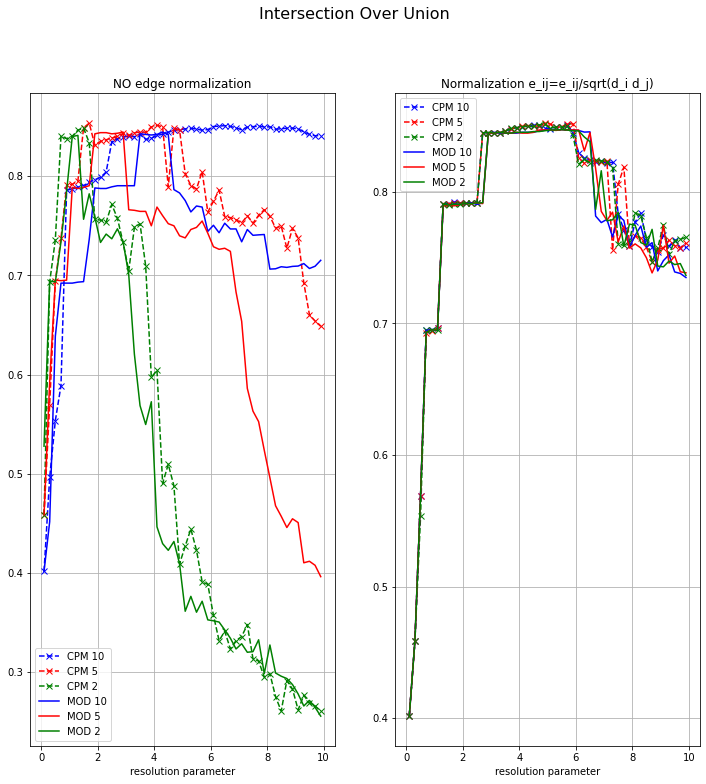

In [51]:
fig, axs = plt.subplots(ncols=2, figsize=(12,12))
fig.suptitle('Intersection Over Union', fontsize=16)

ax0 = axs[0]
ax1 = axs[1]

ax0.plot(sweep_CPM_radius_10_NO_normalization["resolution_list"],sweep_CPM_radius_10_NO_normalization["iou_list"], 'x--', label="CPM 10",color="blue")
ax0.plot(sweep_CPM_radius_5_NO_normalization["resolution_list"],sweep_CPM_radius_5_NO_normalization["iou_list"], 'x--', label="CPM 5",color="red")
ax0.plot(sweep_CPM_radius_2_NO_normalization["resolution_list"],sweep_CPM_radius_2_NO_normalization["iou_list"], 'x--', label="CPM 2",color="green")
ax0.plot(sweep_MODULARITY_radius_10_NO_normalization["resolution_list"],sweep_MODULARITY_radius_10_NO_normalization["iou_list"], '-', label="MOD 10", color="blue")
ax0.plot(sweep_MODULARITY_radius_5_NO_normalization["resolution_list"],sweep_MODULARITY_radius_5_NO_normalization["iou_list"], '-', label="MOD 5", color="red")
ax0.plot(sweep_MODULARITY_radius_2_NO_normalization["resolution_list"],sweep_MODULARITY_radius_2_NO_normalization["iou_list"], '-', label="MOD 2", color="green")
ax0.grid()
ax0.legend()
ax0.set_title("NO edge normalization")
ax0.set_xlabel('resolution parameter')

ax1.plot(sweep_CPM_radius_10_YES_normalization["resolution_list"],sweep_CPM_radius_10_YES_normalization["iou_list"], 'x--', label="CPM 10",color="blue")
ax1.plot(sweep_CPM_radius_5_YES_normalization["resolution_list"],sweep_CPM_radius_5_YES_normalization["iou_list"], 'x--', label="CPM 5",color="red")
ax1.plot(sweep_CPM_radius_2_YES_normalization["resolution_list"],sweep_CPM_radius_2_YES_normalization["iou_list"], 'x--', label="CPM 2",color="green")
ax1.plot(sweep_MODULARITY_radius_10_YES_normalization["resolution_list"],sweep_MODULARITY_radius_10_YES_normalization["iou_list"], '-', label="MOD 10", color="blue")
ax1.plot(sweep_MODULARITY_radius_5_YES_normalization["resolution_list"],sweep_MODULARITY_radius_5_YES_normalization["iou_list"], '-', label="MOD 5", color="red")
ax1.plot(sweep_MODULARITY_radius_2_YES_normalization["resolution_list"],sweep_MODULARITY_radius_2_YES_normalization["iou_list"], '-', label="MOD 2", color="green")
ax1.grid()
ax1.legend()
ax1.set_title("Normalization e_ij=e_ij/sqrt(d_i d_j)")
ax1.set_xlabel('resolution parameter')


Text(0.5, 0, 'resolution parameter')

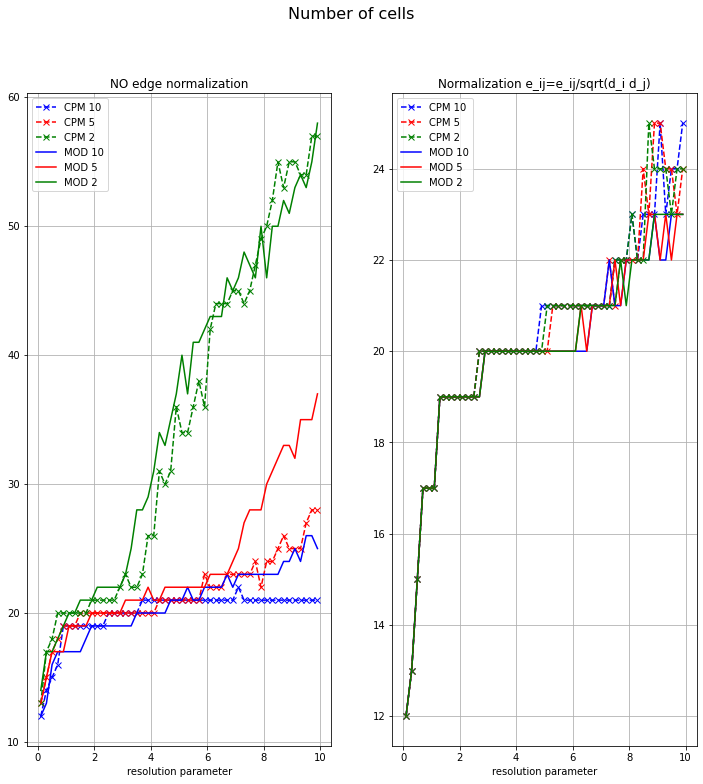

In [52]:
fig, axs = plt.subplots(ncols=2, figsize=(12,12))
fig.suptitle('Number of cells', fontsize=16)

ax0 = axs[0]
ax1 = axs[1]

ax0.plot(sweep_CPM_radius_10_NO_normalization["resolution_list"],sweep_CPM_radius_10_NO_normalization["ncell_list"], 'x--', label="CPM 10",color="blue")
ax0.plot(sweep_CPM_radius_5_NO_normalization["resolution_list"],sweep_CPM_radius_5_NO_normalization["ncell_list"], 'x--', label="CPM 5",color="red")
ax0.plot(sweep_CPM_radius_2_NO_normalization["resolution_list"],sweep_CPM_radius_2_NO_normalization["ncell_list"], 'x--', label="CPM 2",color="green")
ax0.plot(sweep_MODULARITY_radius_10_NO_normalization["resolution_list"],sweep_MODULARITY_radius_10_NO_normalization["ncell_list"], '-', label="MOD 10", color="blue")
ax0.plot(sweep_MODULARITY_radius_5_NO_normalization["resolution_list"],sweep_MODULARITY_radius_5_NO_normalization["ncell_list"], '-', label="MOD 5", color="red")
ax0.plot(sweep_MODULARITY_radius_2_NO_normalization["resolution_list"],sweep_MODULARITY_radius_2_NO_normalization["ncell_list"], '-', label="MOD 2", color="green")
ax0.grid()
ax0.legend()
ax0.set_title("NO edge normalization")
ax0.set_xlabel('resolution parameter')

ax1.plot(sweep_CPM_radius_10_YES_normalization["resolution_list"],sweep_CPM_radius_10_YES_normalization["ncell_list"], 'x--', label="CPM 10",color="blue")
ax1.plot(sweep_CPM_radius_5_YES_normalization["resolution_list"],sweep_CPM_radius_5_YES_normalization["ncell_list"], 'x--', label="CPM 5",color="red")
ax1.plot(sweep_CPM_radius_2_YES_normalization["resolution_list"],sweep_CPM_radius_2_YES_normalization["ncell_list"], 'x--', label="CPM 2",color="green")
ax1.plot(sweep_MODULARITY_radius_10_YES_normalization["resolution_list"],sweep_MODULARITY_radius_10_YES_normalization["ncell_list"], '-', label="MOD 10", color="blue")
ax1.plot(sweep_MODULARITY_radius_5_YES_normalization["resolution_list"],sweep_MODULARITY_radius_5_YES_normalization["ncell_list"], '-', label="MOD 5", color="red")
ax1.plot(sweep_MODULARITY_radius_2_YES_normalization["resolution_list"],sweep_MODULARITY_radius_2_YES_normalization["ncell_list"], '-', label="MOD 2", color="green")
ax1.grid()
ax1.legend()
ax1.set_title("Normalization e_ij=e_ij/sqrt(d_i d_j)")
ax1.set_xlabel('resolution parameter')

# SHOW A VIDEO WITH AND WITHOUT EDGE NORMALIZATION

In [53]:
show_video(dictionary=sweep_CPM_radius_5_YES_normalization, interval=500, nbins=50, hist_range=(0,200))

In [54]:
show_video(dictionary=sweep_CPM_radius_5_NO_normalization, interval=500, nbins=50, hist_range=(0,200))

In [64]:
sweep_CPM_radius_5_YES_normalization["resolution_list"]

[autoreload of MODULES.graph_clustering failed: Traceback (most recent call last):
  File "/Users/ldalessi/anaconda3/envs/pyro/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/Users/ldalessi/anaconda3/envs/pyro/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/Users/ldalessi/anaconda3/envs/pyro/lib/python3.8/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/Users/ldalessi/anaconda3/envs/pyro/lib/python3.8/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 604, in _exec
  File "<frozen importlib._bootstrap_external>", line 779, in exec_module
  File "<frozen importlib._bootstrap_external>", line 916, in get_code
  File "<frozen importlib._bootstrap_external>", line 846, in source_to_code
  File "<frozen importlib._bootstrap>", line 

[0.1,
 0.30000000000000004,
 0.5000000000000001,
 0.7000000000000001,
 0.9000000000000001,
 1.1000000000000003,
 1.3000000000000003,
 1.5000000000000004,
 1.7000000000000004,
 1.9000000000000004,
 2.1000000000000005,
 2.3000000000000007,
 2.5000000000000004,
 2.7000000000000006,
 2.900000000000001,
 3.1000000000000005,
 3.3000000000000007,
 3.500000000000001,
 3.7000000000000006,
 3.900000000000001,
 4.1000000000000005,
 4.300000000000001,
 4.500000000000001,
 4.7,
 4.9,
 5.1000000000000005,
 5.300000000000001,
 5.500000000000001,
 5.700000000000001,
 5.9,
 6.1000000000000005,
 6.300000000000001,
 6.500000000000001,
 6.700000000000001,
 6.900000000000001,
 7.100000000000001,
 7.300000000000001,
 7.500000000000001,
 7.700000000000001,
 7.900000000000001,
 8.100000000000001,
 8.3,
 8.500000000000002,
 8.700000000000001,
 8.900000000000002,
 9.100000000000001,
 9.3,
 9.500000000000002,
 9.700000000000001,
 9.900000000000002]

# MANUAL ANALYSIS

In [55]:
tiling = tiling_original.reduce_similarity_radius(new_radius = 2)
g = GraphSegmentation(tiling_original, min_fg_prob=0.1, min_edge_weight=0.1, normalize_graph_edges=True)

In [56]:
# graph summary

g.graph.summary()

'IGRAPH U-W- 3037 330271 -- \n+ attr: total_edge_weight (g), total_nodes (g), label (v), size (v), weight (e)'

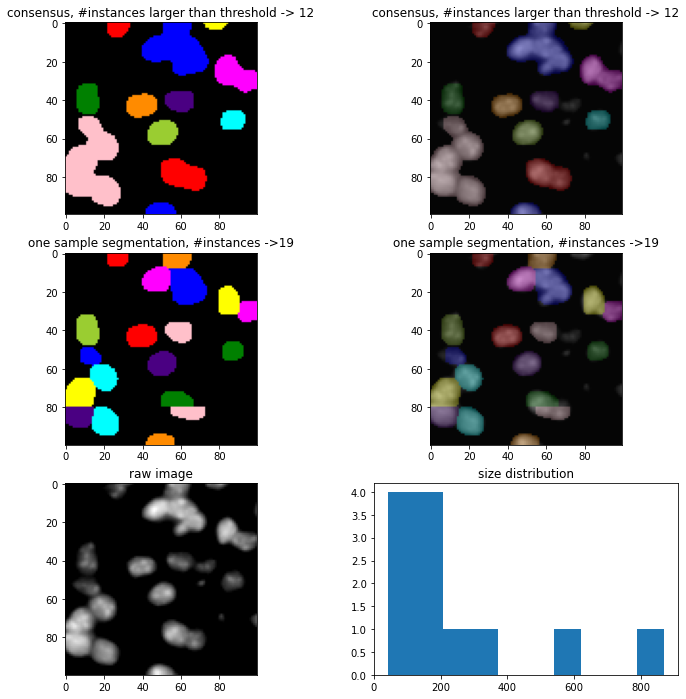

In [57]:
# show the connected components
_ = g.plot_cc()

0.8206852674484253 2 2.5450046062469482


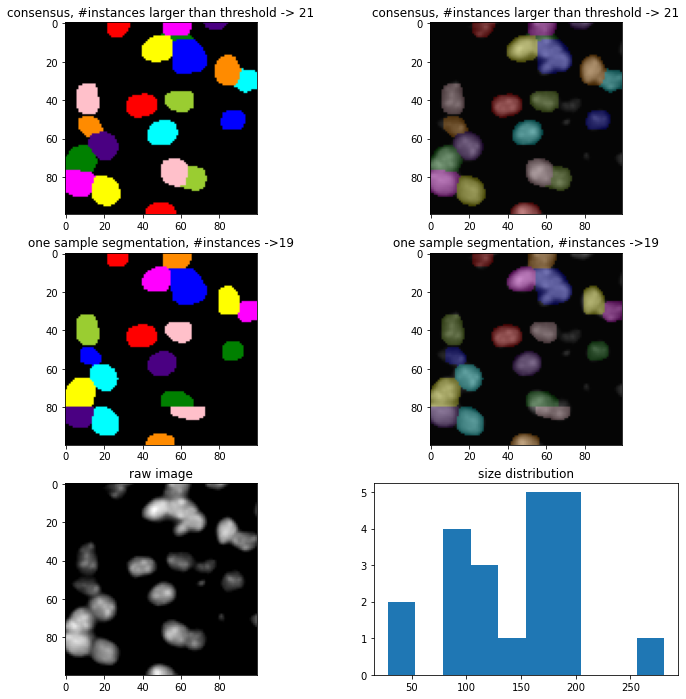

In [59]:
# print 
partition = g.find_partition_leiden(resolution=6.0, CPM_or_modularity="CPM", each_cc_separately=True).filter_by_size(min_size=10)
seg_mask = g.partition_2_mask(partition)
concordance = partition.concordance_with_partition(other_partition=g.partition_sample_segmask)
print(concordance.iou, concordance.delta_n, concordance.mutual_information)
_ = g.plot_partition(partition, size_threshold=0, figsize=(12,12), density=False, bins=10) #, range=(10,300), windows=[1000,1100,2000,2100])